In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for our plots
sns.set(style="whitegrid")

In [2]:
# load dataset
df_raw = pd.read_csv(r"C:\Users\Lilian\Downloads\online_retail_II.csv\online_retail_II.csv")

In [3]:
df_filtered = df_raw.copy() # Start with a copy to avoid touching the raw data
df_filtered['Invoice'] = df_filtered['Invoice'].astype(str)

In [4]:
# Remove rows with cancelled orders
df_filtered = df_filtered[~df_filtered['Invoice'].str.startswith('C')]

In [5]:
df_filtered = df_filtered.dropna(subset=['Customer ID'])

In [6]:
df_filtered = df_filtered[df_filtered['Quantity'] > 0]

In [7]:
df = df_filtered.copy()

In [8]:
#Feature engineering -- date, which was object, to datetime, calculating total price,
#extracting month, day of week, and hour of day from date.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['Price']
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['HourOfDay'] = df['InvoiceDate'].dt.hour

In [15]:
# Get all unique months from our final cleaned data and sort them
unique_months = sorted(df['Month'].unique())

# We now know the last entry is an incomplete December, so we explicitly skip it.
# latest_month should be the last FULL month (November).
# previous_month should be the one before that (October).
latest_month = unique_months[-2]
previous_month = unique_months[-3]

print(f"Corrected Analysis Period: Comparing {previous_month} and {latest_month}\n")

Corrected Analysis Period: Comparing 2011-10 and 2011-11



In [16]:
print("--- Confirming the Business Problem ---")
monthly_stats = df.groupby('Month').agg(
    unique_invoices=('Invoice', 'nunique'),
    unique_customers=('Customer ID', 'nunique')
)
monthly_stats['conversion_rate'] = (monthly_stats['unique_invoices'] / monthly_stats['unique_customers']) * 100
last_two_months_stats = monthly_stats.loc[[previous_month, latest_month]]
rate_prev = last_two_months_stats['conversion_rate'].iloc[0]
rate_latest = last_two_months_stats['conversion_rate'].iloc[1]
percent_drop = ((rate_prev - rate_latest) / rate_prev) * 100
print(last_two_months_stats)
print(f"\nResult: The corrected conversion rate dropped by {percent_drop:.2f}%.\n")

--- Confirming the Business Problem ---
         unique_invoices  unique_customers  conversion_rate
Month                                                      
2011-10             1929              1364       141.422287
2011-11             2658              1665       159.639640

Result: The corrected conversion rate dropped by -12.88%.



In [18]:
print("\n--- Hypothesis 1: Which country drove the customer INCREASE? ---")

# Use pivot_table to create the summary, which is more robust
country_customers = df.pivot_table(
    index='Country',
    columns='Month',
    values='Customer ID',
    aggfunc='nunique'
).fillna(0)

# This calculation will now work correctly
country_customers['customer_change'] = country_customers[latest_month] - country_customers[previous_month]

# Sort to find the biggest increases
biggest_country_increases = country_customers.sort_values('customer_change', ascending=False).head(5)

print("Top 5 Countries with the Largest Increase in Unique Customers:")
print(biggest_country_increases[['customer_change']])


--- Hypothesis 1: Which country drove the customer INCREASE? ---
Top 5 Countries with the Largest Increase in Unique Customers:
Month           customer_change
Country                        
United Kingdom            276.0
France                     12.0
Germany                     6.0
Spain                       5.0
Italy                       4.0


In [20]:
print("\n--- Hypothesis 2: Which products drove the sales INCREASE? ---")

# Use pivot_table to reshape the data reliably
product_sales = df.pivot_table(
    index='Description',
    columns='Month',
    values='TotalPrice',
    aggfunc='sum'
).fillna(0)

# This calculation will now work correctly
product_sales['sales_change'] = product_sales[latest_month] - product_sales[previous_month]

# Sort to find the biggest increases
biggest_increases = product_sales.sort_values('sales_change', ascending=False).head(10)

print("Top 10 Products with the Largest Sales Increase:")
print(biggest_increases[['sales_change']])


--- Hypothesis 2: Which products drove the sales INCREASE? ---
Top 10 Products with the Largest Sales Increase:
Month                               sales_change
Description                                     
RABBIT NIGHT LIGHT                      11313.38
WHITE HANGING HEART T-LIGHT HOLDER       9291.29
PAPER CHAIN KIT 50'S CHRISTMAS           7284.52
CHILLI LIGHTS                            5822.34
BLACK RECORD COVER FRAME                 5321.28
PAPER CHAIN KIT VINTAGE CHRISTMAS        4056.96
ASSORTED COLOUR BIRD ORNAMENT            3867.43
HOT WATER BOTTLE KEEP CALM               3458.55
HEART OF WICKER LARGE                    3337.08
RED HANGING HEART T-LIGHT HOLDER         3107.23


In [22]:
print("\n--- Hypothesis 3: Which customer segment grew the most? ---")

# --- First, create the 'customer_type' column ---
df['first_purchase_month'] = df.groupby('Customer ID')['Month'].transform('min')
df['customer_type'] = 'Returning'
df.loc[df['Month'] == df['first_purchase_month'], 'customer_type'] = 'New'


# --- Now, run the analysis using pivot_table ---
customer_type_stats = df.pivot_table(
    index='customer_type',
    columns='Month',
    values='Customer ID',
    aggfunc='nunique'
).fillna(0)

customer_type_stats['segment_change'] = customer_type_stats[latest_month] - customer_type_stats[previous_month]

print("Change in Unique Customers by Segment:")
print(customer_type_stats[['segment_change']])


--- Hypothesis 3: Which customer segment grew the most? ---
Change in Unique Customers by Segment:
Month          segment_change
customer_type                
New                     -29.0
Returning               330.0


C:\Users\Lilian\AppData\Local\Temp\ipykernel_10592\3084116531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_type_stats.index, y='segment_change', data=customer_type_stats, palette=['#3498db', '#e74c3c'])


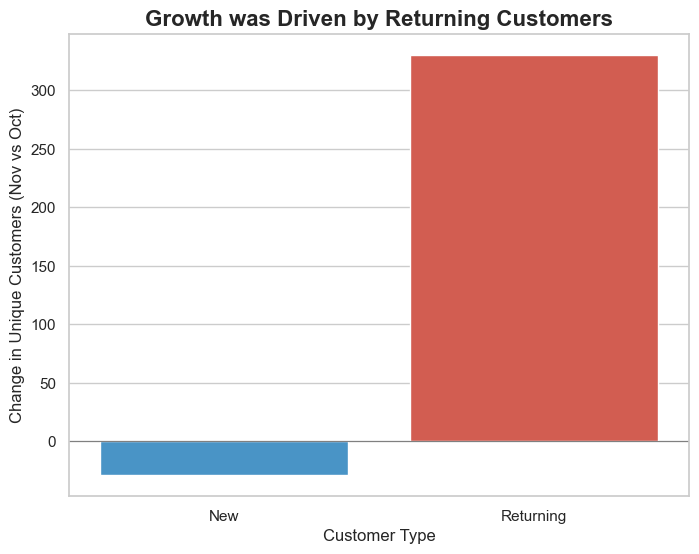

In [23]:
# --- Plotting Code for Hypothesis 3 ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the bar plot
sns.barplot(x=customer_type_stats.index, y='segment_change', data=customer_type_stats, palette=['#3498db', '#e74c3c'])

# Add a horizontal line at zero for reference
plt.axhline(0, color='grey', linewidth=0.8)

# Add titles and labels for clarity
plt.title('Growth was Driven by Returning Customers', fontsize=16, weight='bold')
plt.xlabel('Customer Type', fontsize=12)
plt.ylabel('Change in Unique Customers (Nov vs Oct)', fontsize=12)

# Save the figure for your post
plt.savefig('customer_segments_chart.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

C:\Users\Lilian\AppData\Local\Temp\ipykernel_10592\2351438483.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sales_change', y=biggest_increases.index, data=biggest_increases, palette='viridis')


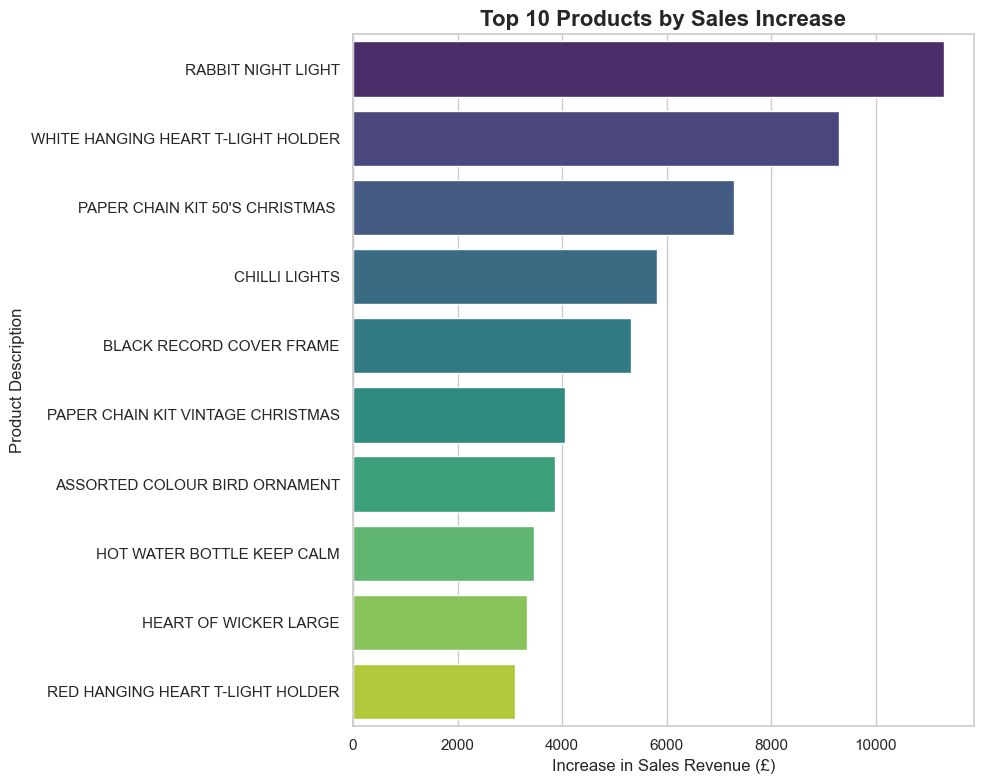

In [24]:
# --- Plotting Code for Hypothesis 2 ---

# Set the figure size
plt.figure(figsize=(10, 8))

# Create the horizontal bar plot
sns.barplot(x='sales_change', y=biggest_increases.index, data=biggest_increases, palette='viridis')

# Add titles and labels
plt.title('Top 10 Products by Sales Increase', fontsize=16, weight='bold')
plt.xlabel('Increase in Sales Revenue (£)', fontsize=12)
plt.ylabel('Product Description', fontsize=12)

# Ensure layout is tight
plt.tight_layout()

# Save the figure for your post
plt.savefig('top_products_chart.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()